### A dirty little trick to avoid having to deal with the notion of relative path. 

In [1]:
import os
os.chdir('/home/juagudelo/HOMEdev/drought_pred_hybrid/')

In [2]:
os.getcwd()

'/home/juagudelo/HOMEdev/drought_pred_hybrid'

## From here, this notebook is going to be used to evaluate the best model issued from the hyperparameter tuning over the test set.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
from tqdm import tqdm
from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score, mean_absolute_error

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import models
import utilities

In [4]:
# Fixing a seed to warrant the reproducibility
torch.manual_seed(21)
np.random.seed(21)

In [5]:
# Initializing the model
num_categorical_features=7
num_numerical_features=22
num_time_series_features=21
batch_size=128
output_weeks=6
# Hyperparameters
hidden_size= 340
num_lstm_layers= 8
embedding_dims= 270
num_fc_tabular_layers= 4
num_fc_combined_layers= 1
dropout= 0.3

In [6]:
# Importing the list of unique categories for the categorical features
with open(f"data/processed_dataFrames/list_cat.pickle", "rb") as f:
    list_cat = pickle.load(f)

In [7]:
# Setting up the loaders
dfs=utilities.load_dataFrames()
valid_loader=utilities.create_dataLoader(X_static=dfs["X_tabular_valid"],
                                         X_static_cat=dfs["X_tabular_cat_valid"],
                                         X_time=dfs["X_time_valid"],
                                         y_target=dfs["y_target_valid"],
                                         output_weeks=output_weeks,
                                         y_past=None,
                                         batch_size=128,
                                         shuffle=False
                                         )
test_loader=utilities.create_dataLoader(X_static=dfs["X_tabular_test"],
                                        X_static_cat=dfs["X_tabular_cat_test"],
                                        X_time=dfs["X_time_test"],
                                        y_target=dfs["y_target_test"],
                                        output_weeks=output_weeks,
                                        y_past=None,
                                        batch_size=128,
                                        shuffle=False
                                        )

In [8]:
test = iter(valid_loader)
X_static, X_static_cat, X_time, y_target = next(test)

In [9]:
X_static_cat.dtype

torch.int64

In [10]:
y_target.round().to(dtype=torch.int8)

tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [2, 3, 3, 3, 2, 2],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [2, 3, 3, 2, 2, 2],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [2, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0,

In [11]:
# set up the device
device=torch.device("cpu")
print(f"Using device: {device}")
print(torch.cuda.get_device_name(device=None))

model = models.HybridModel(num_categorical_features,
                           list_cat,
                           num_numerical_features,
                           num_time_series_features,
                           hidden_size,
                           num_lstm_layers,
                           dropout,
                           embedding_dims,
                           num_fc_tabular_layers,
                           num_fc_combined_layers,
                           output_size=output_weeks,
)

model.load_state_dict(torch.load("models/MH_Hyper/MH_Hyper_12.pt", weights_only=True))
# model.load_state_dict(torch.load("models/MH_Hybrid_Ablation/MH_Hybrid_Ablation_entire.pt", weights_only=True))
model.to(device)

Using device: cpu
NVIDIA T1000 8GB


HybridModel(
  (embeddings): ModuleList(
    (0-4): 5 x Embedding(7, 270)
    (5): Embedding(6, 270)
    (6): Embedding(8, 270)
  )
  (tabular_fc_layers): Sequential(
    (0): Linear(in_features=1912, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU()
  )
  (lstm): LSTM(21, 340, num_layers=8, batch_first=True)
  (attention): Linear(in_features=340, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc_after_context): Linear(in_features=340, out_features=64, bias=True)
  (combined_fc_layers): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Li

In [12]:
def predict(x, static, static_cat):
    out = model(static_cat, static, x)
    return out

In [21]:
dict_map = {
    "y_pred": [],
    "y_pred_rounded": [],
    # "fips": [],
    # "date": [],
    "y_true": [],
    "week": [],
}
i = 0
for static, static_cat, x, y in tqdm(
    valid_loader,
    desc="Test predictions...",
):
    x, static, y = x.to(device), static.to(device), y.to(device)
    with torch.no_grad():
        pred = predict(x, static, static_cat).clone().detach()
    for w in range(output_weeks):
        dict_map["y_pred"] += [float(p[w]) for p in pred]
        dict_map["y_pred_rounded"] += [int(p.round()[w]) for p in pred]
        # dict_map["fips"] += [f[1][0] for f in valid_fips[i : i + len(x)]]
        # dict_map["date"] += [f[1][1] for f in valid_fips[i : i + len(x)]]
        dict_map["y_true"] += [float(item[w]) for item in y]
        dict_map["week"] += [w] * len(x)
    i += len(x)
df = pd.DataFrame(dict_map)

Test predictions...: 100%|██████████| 69/69 [00:45<00:00,  1.52it/s]


In [22]:
df

,y_pred,y_pred_rounded,y_true,week
0,0.048410,0,0.0000,0
1,0.105712,0,0.0000,0
2,0.087454,0,0.0000,0
3,0.045518,0,0.0000,0
4,0.591415,1,0.7767,0
...,...,...,...,...
52483,0.200711,0,0.9964,5
52484,1.137668,1,1.9211,5
52485,0.221456,0,0.0000,5
52486,0.201621,0,0.0000,5


In [23]:
for w in range(6):
    wdf = df[df['week']==w]
    mae = mean_absolute_error(wdf['y_true'], wdf['y_pred']).round(3)
    f1 = f1_score(wdf['y_true'].round(),wdf['y_pred_rounded'], average='macro').round(3)
    print(f"Week {w+1}", f"MAE {mae}", f"F1 {f1}")

Week 1 MAE 0.147 F1 0.752
Week 2 MAE 0.21 F1 0.668
Week 3 MAE 0.25 F1 0.624
Week 4 MAE 0.299 F1 0.559
Week 5 MAE 0.341 F1 0.524
Week 6 MAE 0.381 F1 0.469


(array([6.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        8.0000e+00, 1.4000e+01, 1.4000e+01, 2.4000e+01, 3.0000e+01,
        4.4000e+01, 7.8000e+01, 1.1300e+02, 1.6600e+02, 1.7800e+02,
        2.6200e+02, 4.5900e+02, 6.5200e+02, 8.9900e+02, 1.4280e+03,
        3.3290e+03, 1.5990e+04, 1.6743e+04, 2.8510e+03, 2.1530e+03,
        1.7440e+03, 1.7080e+03, 1.7670e+03, 5.9500e+02, 3.7400e+02,
        2.5800e+02, 2.2900e+02, 1.7200e+02, 1.0500e+02, 3.0000e+01,
        2.2000e+01, 1.6000e+01, 1.3000e+01, 8.0000e+00, 4.0000e+00]),
 array([-3.7604661 , -3.5913566 , -3.4222471 , -3.2531376 , -3.0840281 ,
        -2.9149186 , -2.7458091 , -2.5766996 , -2.4075901 , -2.2384806 ,
        -2.0693711 , -1.9002616 , -1.73115211, -1.56204261, -1.39293311,
        -1.22382361, -1.05471411, -0.88560461, -0.71649511, -0.54738561,
        -0.37827611, -0.20916661, -0.04005711,  0.12905239,  0.29816189,
         0.46727139,  0.63638089,  0.80549039,  0.97459989,  1.14370939,
         1.31281

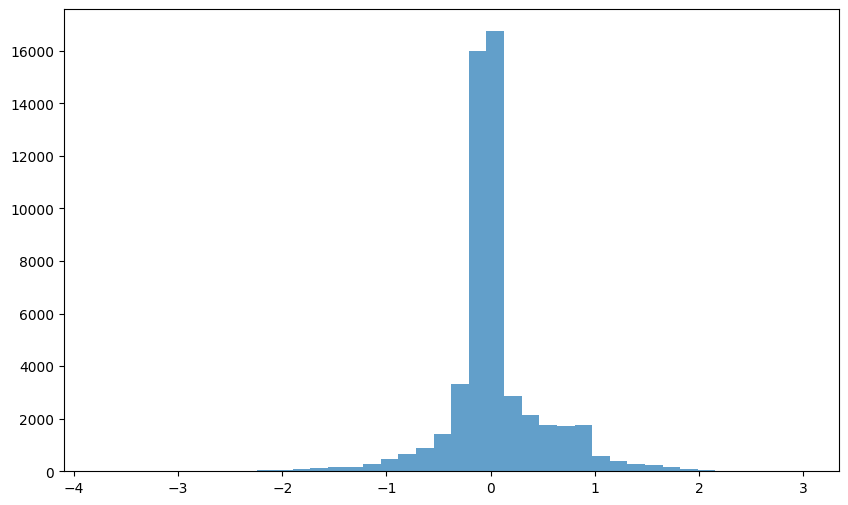

In [24]:
# Error distribution
plt.figure(figsize=(10, 6))
plt.hist((df['y_true'] - df['y_pred']), bins=40, alpha=0.7, label='error')

# The next section evaluates the ablation study

<Axes: >

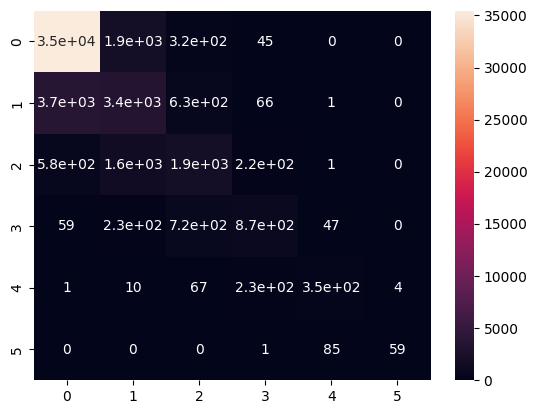

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, root_mean_squared_error
import seaborn
seaborn.heatmap(confusion_matrix(df['y_true'].round(), df['y_pred'].round()), annot=True)

In [17]:
# setting data to calculate the ROC AUC
def calculate_metrics(model_name, model_path):

    device=torch.device("cpu")
    print(f"Using device: {device}")
    print(torch.cuda.get_device_name(device=None))

    model = models.HybridModel(num_categorical_features,
                            list_cat,
                            num_numerical_features,
                            num_time_series_features,
                            hidden_size,
                            num_lstm_layers,
                            dropout,
                            embedding_dims,
                            num_fc_tabular_layers,
                            num_fc_combined_layers,
                            output_size=output_weeks,
    )

    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.to(device)

    dict_map = {
        "y_pred": [],
        "y_pred_rounded": [],
        "y_true": [],
        "week": [],
    }
    i = 0
    for static, static_cat, x, y in tqdm(
        test_loader,
        desc="Test predictions...",
    ):
        x, static, y = x.to(device), static.to(device), y.to(device)
        with torch.no_grad():
            pred = predict(x, static, static_cat).clone().detach()
        for w in range(output_weeks):
            dict_map["y_pred"] += [float(p[w]) for p in pred]
            dict_map["y_pred_rounded"] += [int(p.round()[w]) for p in pred]
            # dict_map["fips"] += [f[1][0] for f in valid_fips[i : i + len(x)]]
            # dict_map["date"] += [f[1][1] for f in valid_fips[i : i + len(x)]]
            dict_map["y_true"] += [float(item[w]) for item in y]
            dict_map["week"] += [w] * len(x)
        i += len(x)
    df = pd.DataFrame(dict_map)

    # for w in range(6):
    #     wdf = df[df['week']==w]
    #     mae = mean_absolute_error(wdf['y_true'], wdf['y_pred']).round(3)
    #     f1 = f1_score(wdf['y_true'].round(),wdf['y_pred'].round(), average='macro').round(3)
    #     print(f"Week {w+1}", f"MAE {mae}", f"F1 {f1}")

    y_true_roc = df['y_true'].round()
    y_pred_roc = df['y_pred'].round()
    y_pred_for_sklearn = np.array([[0, 0, 0, 0, 0, 0] for i in y_pred_roc])
    for i in range(len(y_pred_roc)):
        y_pred_for_sklearn[i, int(y_pred_roc[i])] = 1

    y_true_for_sklearn = np.array([[0, 0, 0, 0, 0, 0] for i in y_true_roc])
    for i in range(len(y_true_roc)):
        y_true_for_sklearn[i, int(y_true_roc[i])] = 1

    mae = mean_absolute_error(df['y_true'], df['y_pred'])
    rmse = root_mean_squared_error(df['y_true'], df['y_pred'])
    f1 = f1_score(y_true_roc, y_pred_roc, average='macro')
    roc_auc = roc_auc_score(y_true_for_sklearn, y_pred_for_sklearn, multi_class='ovr', average='weighted')
    
    results = pd.DataFrame({'Model': [model_name], 'MAE': [mae], 'RMSE': [rmse], 'F1': [f1], 'ROC_AUC': [roc_auc]})

    return results

In [18]:
ablation_study_schema = [("static", "models/MH_Hyper/MH_Hyper_12.pt"),
                         ("ts_no_att", ""),
                         ("ts", ""),
                         ("static_ts_no_att", ""),
                         ("entire", ""),
                         ]

In [19]:
results_df = pd.DataFrame(columns=['Model', 'MAE', 'RMSE', 'F1', 'ROC_AUC'])

for name, path in ablation_study_schema:
    # Fixing a seed to warrant the reproducibility
    torch.manual_seed(21)
    np.random.seed(21)
    results_df = pd.concat([results_df, calculate_metrics(name, path)])

Using device: cpu
NVIDIA T1000 8GB


Test predictions...:  35%|███▍      | 24/69 [00:18<00:35,  1.28it/s]


KeyboardInterrupt: 

In [17]:
results_df

,Model,MAE,RMSE,F1,ROC_AUC
0,static,0.259596,0.470429,0.589339,0.785717
0,ts_no_att,0.259596,0.470429,0.589339,0.785717
